# CNN для классификации изображений

Возьмем датасет Cats vs Dogs с Kaggle

In [7]:
from keras import models, layers, optimizers, losses, metrics
from keras import optimizers

In [9]:
%run./Datasets/create_cats_dogs_datasets.py

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## Построение сети
Структура будет представлять собой еще один стек слоев `Conv2D` и `MaxPooling2D`. Поскольку задача сложнее, чем классическая игрушечная задача MNIST, сеть, соответственно, будет больше.

In [10]:
# Создание последовательной модели
model = models.Sequential()

# Добавление сверточного слоя с 32 фильтрами размером (3, 3) и функцией активации ReLU,
# входной формы (150, 150, 3) (высота, ширина, количество каналов)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Добавление слоя максимальной подвыборки с размером (2, 2)
model.add(layers.MaxPooling2D((2, 2)))

# Добавление сверточного слоя с 64 фильтрами размером (3, 3) и функцией активации ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Добавление слоя максимальной подвыборки с размером (2, 2)
model.add(layers.MaxPooling2D((2, 2)))

# Добавление сверточного слоя с 128 фильтрами размером (3, 3) и функцией активации ReLU
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Добавление слоя максимальной подвыборки с размером (2, 2)
model.add(layers.MaxPooling2D((2, 2)))

# Добавление сверточного слоя с 128 фильтрами размером (3, 3) и функцией активации ReLU
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Добавление слоя максимальной подвыборки с размером (2, 2)
model.add(layers.MaxPooling2D((2, 2)))

# Выпрямление вектора в одномерный
model.add(layers.Flatten())

# Добавление полносвязного слоя с 512 нейронами и функцией активации ReLU
model.add(layers.Dense(512, activation='relu'))

# Добавление полносвязного слоя с 1 нейроном и функцией активации сигмоиды (для бинарной классификации)
model.add(layers.Dense(1, activation='sigmoid'))

# Вывод краткой информации о модели, включая количество параметров и форму каждого слоя
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

#### Скомпилируем модель

In [11]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Предварительная обработка данных

Данные по-прежнему в формате JPEG, поэтому нам нужно обработать их по порядку в соответствующем формате, который можно использовать для загрузки модели. Нам нужно:
- прочитать файлы;
- декодировать содержимое JPEG в пиксельную сетку RGB;
- преобразовать сетки в тензоры с плавающей запятой;
- преобразовать значения пикселей в значения, включенные в интервал `[0, 1]`

В Keras есть библиотеки, которые позволяют автоматизировать эти операции, возвращая генераторы, которые выполняют требуемые задачи.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Пути к каталогам с данными обучения и валидации
TRAIN_DIR = "./Datasets/cats_and_dogs_small/train"
VALIDATION_DIR = "./Datasets/cats_and_dogs_small/validation"

# Создание объектов генераторов изображений для масштабирования значений пикселей к диапазону [0, 1]
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)

# Создание генератора данных для обучения на основе изображений из каталога TRAIN_DIR
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,  # Путь к каталогу с обучающими изображениями
    target_size=(150, 150),  # Размер всех изображений будет изменен до 150x150
    batch_size=20,  # Размер пакета, который будет возвращен генератором
    class_mode='binary'  # Поскольку это двоичная классификация, используется 'binary'
)

# Создание генератора данных для валидации на основе изображений из каталога VALIDATION_DIR
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,  # Путь к каталогу с валидационными изображениями
    target_size=(150, 150),  # Размер всех изображений будет изменен до 150x150
    batch_size=20,  # Размер пакета, который будет возвращен генератором
    class_mode='binary'  # Поскольку это двоичная классификация, используется 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
from PIL import Image
import os


def verify_images(directory):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img.verify()  # Проверяем, что изображение можно открыть
            except (IOError, SyntaxError) as e:
                print(f'Bad file: {filepath} - {e}')


# Проверяем изображения в обучающей и валидационной директориях
verify_images(TRAIN_DIR)
verify_images(VALIDATION_DIR)

Проверка правильности формы данных:

In [19]:
for data_batch, labels_batch in train_generator:
    # Вывод формы пакета данных и пакета меток
    print(f"Форма пакета данных: {data_batch.shape}")
    print(f"Форма пакета меток: {labels_batch.shape}")
    break  # Необходимо, потому что генератор бесконечно выдает пакеты

Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)


## Обучение

Обучите модель, используя генераторы. Новая версия Keras все еще поддерживает `fit_generator`, но она собирается быть устаревшей. Лучше использовать `fit`, который теперь поддерживает генераторы.
Первым аргументом является Python-генератор, который будет бесконечно выдавать пакеты обучающих входных данных и целей (`train_generator`). Поскольку данные генерируются бесконечно, генератору нужно знать, сколько примеров выбрать из генератора, прежде чем объявить эпоху завершенной. Этим занимается аргумент `steps_per_epoch`: после того, как будет выбрано `steps_per_epoch` пакетов из генератора, т.е. после выполнения steps_per_epoch шагов градиентного спуска, процесс обучения перейдет к следующей эпохе. В нашем случае пакеты составляются из 20 примеров, поэтому понадобится 100 пакетов, пока мы не достигнем нашей цели в 2000 примеров.

При использовании `fit_generator` можно передать аргумент `validation_data`, так же как с методом `fit`. Важно отметить, что этот аргумент также может быть генератором данных, но он также может быть кортежем массивов Numpy. Если вы передаете генератор как `validation_data`, то этот генератор ожидает бесконечно выдавать пакеты валидационных данных, и поэтому вы также должны указать аргумент `validation_steps`, который сообщает процессу, сколько пакетов нужно выбрать из валидационного генератора для оценки.

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 19s 192ms/step - loss: 0.6814 - accuracy: 0.5715 - val_loss: 0.6975 - val_accuracy: 0.5490
Epoch 2/30
100/100 [==============================] - 18s 180ms/step - loss: 0.6450 - accuracy: 0.6285 - val_loss: 0.6910 - val_accuracy: 0.5940
Epoch 3/30
100/100 [==============================] - 18s 175ms/step - loss: 0.5991 - accuracy: 0.6810 - val_loss: 0.6390 - val_accuracy: 0.6560
Epoch 4/30
100/100 [==============================] - 17s 174ms/step - loss: 0.5677 - accuracy: 0.7130 - val_loss: 0.5991 - val_accuracy: 0.6930
Epoch 5/30
100/100 [==============================] - 17s 174ms/step - loss: 0.5112 - accuracy: 0.7440 - val_loss: 0.5698 - val_accuracy: 0.7100
Epoch 6/30
100/100 [==============================] - 18s 175ms/step - loss: 0.4742 - accuracy: 0.7745 - val_loss: 0.5469 - val_accuracy: 0.7230
Epoch 7/30
100/100 [==============================] - 17s 174ms/step - loss: 0.4339 - accuracy: 0.8040 - val_loss: 0.5918 - val_ac

#### Сохраним модель в формате .keras

In [22]:
model.save('models/cats_and_dogs.keras')

#### Графики потерь и точности

Ниже представлены характеристики переобучения. Точность обучения линейно увеличивается с течением времени, пока не достигнет 100%, в то время как точность валидации застопорилась на уровне около 72%. Также интересно видеть, насколько шумны кривые потерь и точности валидации.

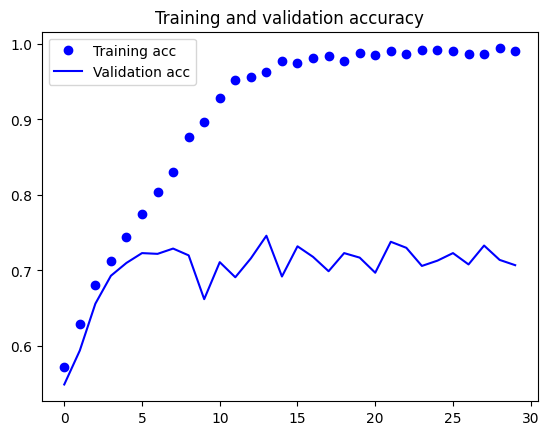

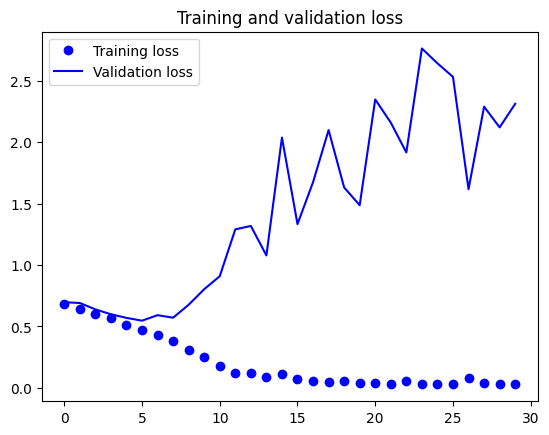

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Борьба с переобучением

Относительно небольшое количество обучающих примеров (2000) может быть одной из возможных основных причин переобучения. Давайте решим эту проблему с помощью новой техники, отличной от рассмотренных ранее (регуляризации и дропаута).

### Использование аугментации данных

Аугментация данных предполагает создание новых данных из существующих образцов путем _увеличения_ образцов с помощью ряда случайных преобразований, которые порождают правдоподобные изображения. В Keras это можно сделать, настроив ряд случайных преобразований, которые будут выполняться над изображениями, считываемыми экземпляром `ImageDataGenerator`

#### Создание генераторов, настроенных на аугментацию данных

Итак, давайте начнем с переопределения `train_generator`, добавив некоторые преобразования аугментации данных. Обратите внимание, что валидационные данные **не будут аугментироваться**.

- `rotation_range` - это значение в градусах (0-180), диапазон, в пределах которого случайным образом поворачиваются изображения;
- `width_shift` и `height_shift` - это диапазоны (как доля от общей ширины или высоты), в пределах которых случайным образом сдвигаются изображения вертикально или горизонтально;
- `shear_range` - для случайного применения сдвигов;
- `zoom_range` - для случайного масштабирования изображений;
- `horizontal_flip` - для случайного отражения половины изображений по горизонтали - актуально, когда нет предположений о горизонтальной асимметрии (например, на фотографиях из реального мира).
- `fill_mode` - это стратегия заполнения новых пикселей, которые могут появиться после поворота или сдвига по ширине/высоте.

In [24]:
train_datagen = ImageDataGenerator(
    # Масштабирование всех изображений на 1/255 и применение дополнения данных
    rescale=1. / 255,
    rotation_range=40,  # Угол поворота в диапазоне [-40, 40] градусов
    width_shift_range=0.2,  # Случайное горизонтальное смещение в диапазоне [-20%, 20%] от ширины
    height_shift_range=0.2,  # Случайное вертикальное смещение в диапазоне [-20%, 20%] от высоты
    shear_range=0.2,  # Случайное смещение по направлению среза в диапазоне [-20%, 20%]
    zoom_range=0.2,  # Случайное масштабирование в диапазоне [0.8, 1.2]
    horizontal_flip=True  # Случайное горизонтальное отражение
)
validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Изменение архитектуры сети

С аугментацией данных мы можем быть уверены, что модель не получит одинаковый вход дважды. Но также верно, что мы не создаем новые данные, а просто перераспределяем существующую информацию. Это означает, что определенные шаблоны могут быть выучены несколько раз, что может быть фактором, действующим против нас в попытке избавиться от переобучения. Для решения этой проблемы мы попробуем добавить слой `Dropout` прямо перед частью классификатора.

In [25]:
model = models.Sequential()

# Добавление сверточного слоя с 32 фильтрами размером (3, 3) и функцией активации ReLU,
# входной формы (150, 150, 3) (высота, ширина, количество каналов)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Добавление слоя максимальной подвыборки с размером (2, 2)
model.add(layers.MaxPooling2D((2, 2)))

# Добавление сверточного слоя с 64 фильтрами размером (3, 3) и функцией активации ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Добавление слоя максимальной подвыборки с размером (2, 2)
model.add(layers.MaxPooling2D((2, 2)))

# Добавление сверточного слоя с 128 фильтрами размером (3, 3) и функцией активации ReLU
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Добавление слоя максимальной подвыборки с размером (2, 2)
model.add(layers.MaxPooling2D((2, 2)))

# Добавление сверточного слоя с 128 фильтрами размером (3, 3) и функцией активации ReLU
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Добавление слоя максимальной подвыборки с размером (2, 2)
model.add(layers.MaxPooling2D((2, 2)))

# Выпрямление вектора в одномерный
model.add(layers.Flatten())

# Применение регуляризации Dropout с коэффициентом 0.5
model.add(layers.Dropout(0.5))

# Добавление полносвязного слоя с 512 нейронами и функцией активации ReLU
model.add(layers.Dense(512, activation='relu'))

# Добавление полносвязного слоя с 1 нейроном и функцией активации сигмоиды (для бинарной классификации)
model.add(layers.Dense(1, activation='sigmoid'))

# Вывод краткой информации о модели, включая количество параметров и форму каждого слоя
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [26]:
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Натренируем новую модельку)))

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=50,
)

Epoch 1/150
100/100 [==============================] - 24s 230ms/step - loss: 0.6991 - accuracy: 0.5035 - val_loss: 0.6917 - val_accuracy: 0.5040
Epoch 2/150
100/100 [==============================] - 22s 223ms/step - loss: 0.6942 - accuracy: 0.5325 - val_loss: 0.6798 - val_accuracy: 0.5820
Epoch 3/150
100/100 [==============================] - 22s 224ms/step - loss: 0.6870 - accuracy: 0.5770 - val_loss: 0.6854 - val_accuracy: 0.5780
Epoch 4/150
100/100 [==============================] - 22s 223ms/step - loss: 0.6812 - accuracy: 0.5895 - val_loss: 0.6514 - val_accuracy: 0.6450
Epoch 5/150
100/100 [==============================] - 22s 222ms/step - loss: 0.6644 - accuracy: 0.6120 - val_loss: 0.6258 - val_accuracy: 0.6460
Epoch 6/150
100/100 [==============================] - 23s 227ms/step - loss: 0.6474 - accuracy: 0.6400 - val_loss: 0.6179 - val_accuracy: 0.6330
Epoch 7/150
100/100 [==============================] - 22s 224ms/step - loss: 0.6411 - accuracy: 0.6305 - val_loss: 0.5959 -

#### Сохраним чекпоинт нашей модели

In [28]:
model.save('models/cats_and_dogs_new.keras')

## Построение графиков результатов (снова)

Благодаря аугментации данных и отсеву (dropout), мы больше не страдаем от переобучения. Несмотря на то что потери на валидации имеют очень высокую дисперсию, они следуют тенденции потерь на обучении. Теперь мы можем достичь точности в 83%, что на 15% выше, чем у модели без регуляризации.

Используя регуляризацию и настройку параметров сети (таких как количество фильтров на сверточном слое или количество слоев в сети), мы, возможно, сможем добиться еще более высокой точности, вероятно, до 86-87%. Однако будет очень сложно достичь большей точности только путем обучения своей собственной сверточной нейронной сети с нуля, просто потому что у нас мало данных для работы.

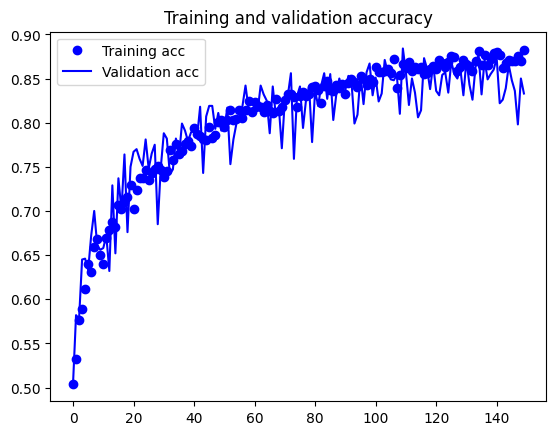

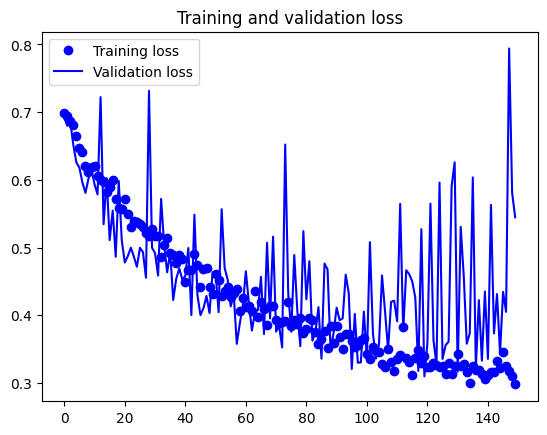

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()